In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os

cwd = Path.cwd()                   
if cwd.name == "nbs":              
    ROOT = cwd.parent.resolve()    
else:
    ROOT = cwd                     
os.chdir(ROOT)

In [3]:
from pixie.viz_utils import *
import trimesh
from pixie.utils import *
from IPython.display import Image, Video
from ipywidgets import Output, GridspecLayout
from IPython import display
from pixie.utils import _find_latest_inference_dir

In [4]:


cfg = load_config()

obj_id = "bonsai" ## [bonsai, bouquet, vasedeck]


cfg.obj_id = obj_id
cfg.material_mode = "neural" #[vlm, neural]
cfg.paths.data_dir = "real_scene_data"
cfg.paths.render_outputs_dir = "real_scene_render_outputs"
cfg.is_objaverse_object = False
cfg = resolve_paths(cfg)
paths = get_output_paths(cfg, cfg.obj_id)
cfg.segmentation.neural.result_id = _find_latest_inference_dir(cfg)

## resolve paths again
cfg = resolve_paths(cfg)
paths = get_output_paths(cfg, cfg.obj_id)
paths

{'data_dir': 'real_scene_data/bonsai',
 'nerf_output': '/home/vlongle/code/pixie-dev/models/bonsai/f3rm',
 'gs_output': '/home/vlongle/code/pixie-dev/models/bonsai/gs',
 'render_output': 'real_scene_render_outputs/bonsai',
 'neural_base_dir': '/home/vlongle/code/pixie-dev/inference_combined_mse_clip_results/20250826_121144/bonsai',
 'physgaussian_output': '/home/vlongle/code/pixie-dev/mpm_sim_outputs/neural/bonsai',
 'blender_output': '/home/vlongle/code/pixie-dev/blender_outputs/bonsai',
 'blend_file_path': 'pixie/blender/empty_scene.blend',
 'blender_gs_addon_path': '/home/vlongle/code/pixie/blender-addon.zip'}

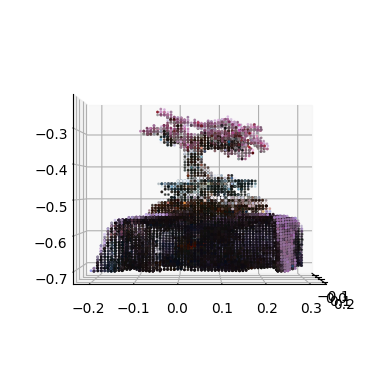

In [5]:
pc = trimesh.load(f"{paths['render_output']}/clip_features_pc.ply")
viz(pc.vertices, pc.colors);

In [6]:
pred_path = get_material_segmentation_path(cfg, paths['render_output'], paths)
pred_pc, pred_feats = load_semantic_ply(pred_path)
pred_feats

{'part_label': memmap([6, 6, 6, ..., 6, 6, 6], dtype=int32),
 'E': array([15.351016 , 15.304461 , 14.87731  , ..., 15.8357725, 15.787883 ,
        14.490429 ], dtype=float32),
 'density': array([6.4753   , 6.3867593, 6.258811 , ..., 6.5176353, 6.552531 ,
        6.4386277], dtype=float32),
 'nu': memmap([0.32326677, 0.3304015 , 0.33524716, ..., 0.31787965, 0.31019688,
         0.32906172], dtype=float32),
 'material_id': memmap([6, 6, 6, ..., 6, 6, 6], dtype=int32)}

In [7]:
config = load_json(join_path(
    "third_party/PhysGaussian",
    get_physics_config_path(cfg, cfg.obj_id, cfg.material_mode, cfg.obj_class)))
rotation_axis = config.get("rotation_axis", [0])
rotation_degree = config.get("rotation_degree", [0])

rotations = [0, 0, 0]
for deg, axis in zip(rotation_degree, rotation_axis):
    rotations[axis] = deg

<Axes3D: >

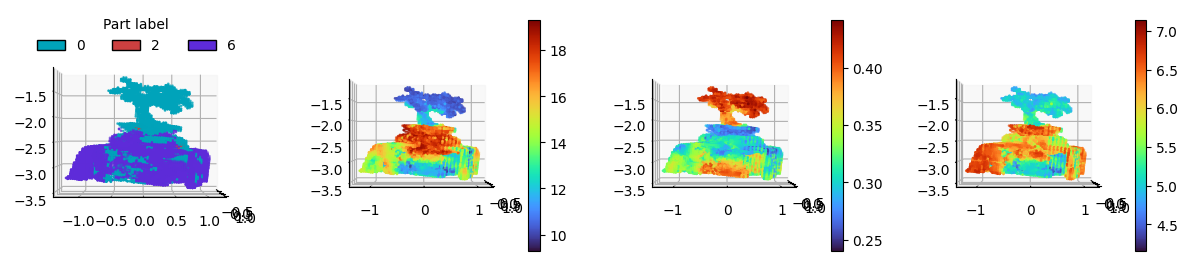

In [9]:
fig, ax = plt.subplots(1, 4,
    subplot_kw={'projection': '3d'},
     figsize=(15, 4))
viz(pred_pc, pred_feats['part_label'], discrete=True, rotation=rotations,
ax=ax[0])
viz(pred_pc, pred_feats['E'], rotation=rotations,
ax=ax[1])
viz(pred_pc, pred_feats['nu'], rotation=rotations,
ax=ax[2])
viz(pred_pc, pred_feats['density'], rotation=rotations,
ax=ax[3])

In [10]:
gs_sim_out_path = f"{paths['physgaussian_output']}/sample_{cfg.physics.sample_id}"
sim_out = Path(gs_sim_out_path) / "frames" / "output.mp4"
Video(sim_out, embed=True)